In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error

### TODO: add Part 2: Testing Data, finish up Age Regression

# Data Cleaning, Inspection
## Part 1: Training Data
First we simply load in the data and have a look

In [199]:
train_df = pd.read_csv("train.csv")
print('Total dataset dimensions: ' + str(train_df.shape))
samples = train_df.shape[0]         #save number of sample for later verification purposes
train_df.head()

Total dataset dimensions: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [200]:
#check to make sure dtypes are what they should be
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [201]:
#drop names because they probably don't impact decision, might change later
train_df = train_df.drop(["Name"], axis=1)

Check data for incompleteness:

In [202]:
#check columns for incompleteness, True => column missing data
for column in train_df:
    print(column + ': ', end='')
    print(train_df[column].isnull().any())

print()
print('samples with NaN age: ' + str(train_df[train_df['Age'].isnull()].shape[0]))
train_df[train_df['Age'].isnull()].head()
#may be able to predict age from complete data first

PassengerId: False
Survived: False
Pclass: False
Sex: False
Age: True
SibSp: False
Parch: False
Ticket: False
Fare: False
Cabin: True
Embarked: True

samples with NaN age: 177


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,female,NaN,0,0,330959,7.8792,NaN,Q


In [204]:
print('samples with NaN embarked: ' + str(train_df[train_df['Embarked'].isnull()].shape[0]))
train_df[train_df['Embarked'].isnull()].head()

samples with NaN embarked: 2


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,female,62.0,0,0,113572,80.0,B28,NaN


Features `'Age'` and `'Embarked'` are both missing data. Since `'Embarked'` is missing for only two samples, we can leave it as is and have the a category for null in one-hot encoding later. `'Age'` will have to be handled since a significant ($\frac{177}{891} = 19.87\%$) portion of samples were missing `'Age'`. Next take a brief look at the distributions for the continuous variables.

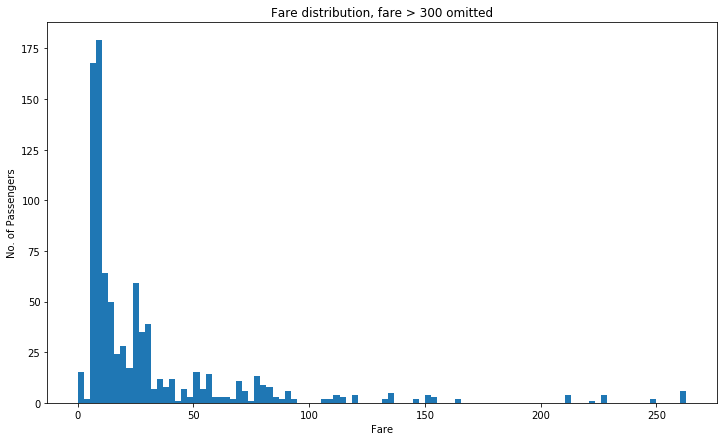

In [205]:
plt.figure(figsize=(12,7))
plt.hist(train_df[train_df['Fare'] < 300]['Fare'] , bins=100)
plt.xlabel('Fare')
plt.ylabel('No. of Passengers')
plt.title('Fare distribution, fare > 300 omitted')
plt.show()

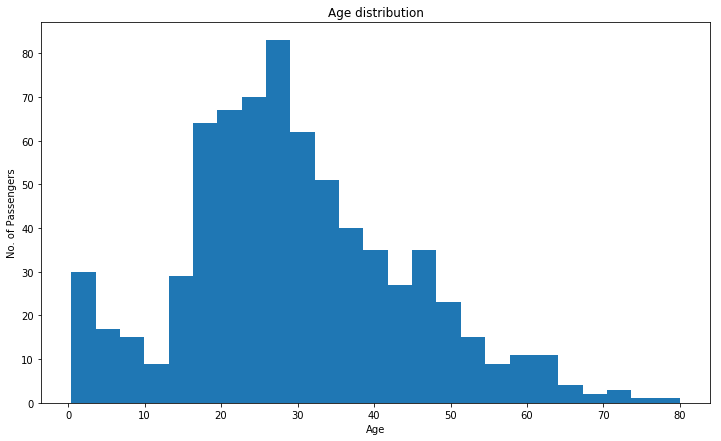

In [206]:
plt.figure(figsize=(12,7))
plt.hist(train_df['Age'], bins=25)
plt.xlabel('Age')
plt.ylabel('No. of Passengers')
plt.title('Age distribution')
plt.show()

# Preprocessing

In [207]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S


In [208]:
train_df['Cabin'].value_counts().head()
#for cabin we can either one-hot everything
#or pull the letter out (assuming it means something)

G6             4
B96 B98        4
C23 C25 C27    4
F2             3
D              3
Name: Cabin, dtype: int64

In [209]:
#one hot encoding and managing which features we want
ml_df = train_df.drop(['Ticket','Cabin'], axis=1)
ml_df = pd.get_dummies(ml_df, columns=['Pclass','Embarked','Sex'])
print('Dataframe for ML dimensions: ' + str(ml_df.shape))
ml_df.head()

Dataframe for ML dimensions: (891, 14)


,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,0,22.0,1,0,7.2500,0,0,1,0,0,1,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,1,0,0,1,0
2,3,1,26.0,0,0,7.9250,0,0,1,0,0,1,1,0
3,4,1,35.0,1,0,53.1000,1,0,0,0,0,1,1,0
4,5,0,35.0,0,0,8.0500,0,0,1,0,0,1,0,1


In [218]:
#get the test data now too
test_df = pd.read_csv('test.csv')

check_df = test_df.drop(['Name','Ticket','Cabin'],axis=1)
check_df = pd.get_dummies(check_df, columns=['Pclass','Embarked','Sex'])
print('Test Dataframe dimensions: ' + str(check_df.shape))
check_df.head()

Test Dataframe dimensions: (418, 13)


,PassengerId,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,892,34.5,0,0,7.8292,0,0,1,0,1,0,0,1
1,893,47.0,1,0,7.0000,0,0,1,0,0,1,1,0
2,894,62.0,0,0,9.6875,0,1,0,0,1,0,0,1
3,895,27.0,0,0,8.6625,0,0,1,0,0,1,0,1
4,896,22.0,1,1,12.2875,0,0,1,0,0,1,1,0


# Predicting Age
We want to fill in for missing ages since NaNs were relatively high for this feature. We can train a random forest regression model off of the samples with known ages, and use it to fill in the samples with NaN ages. The process will follow this workflow:

- Take samples with known age (`[Age].notna()`) from overall training dataset, removing `['Age','Survived']` (as we won't know `'Survived'` during testing) to form `age_train_X`. Use `'Age'` as `age_train_Y`.
- Train the RF regression model on `age_train_X`, tuning hyperparameters with `GridSearchCV` as necessary. 
- Check the model's generalizability (test accuracy) on the test dataset. Do this by getting the nonnull age samples from the test data and checking how well we can predict them.

(Note: Test data's samples with null age won't be used in this part as we have no way to verify if the predicted ages for those samples are correct. Our ultimate goal is to fill in train data's missing ages to improve model training, and fill in test data's missing ages to improve model prediction (as if preprocessing) automatically (assuming our predicted age is accurate enough)

In [ ]:
def train_age_regressor(raw_df):
    ''' Function to train random forest regressor on samples with known age.
        
        Params:
        raw_df(DataFrame): The raw overall training dataframe.
        
        Returns:
        best_params(dict): Best hyperparameters for the model found in GridSearchCV.
        pred_train_Y(list): List of ages predicted on training dataset in order for the known age samples.
        age_train_Y(list): List of the actual ages of the training dataset in order.
        
    '''
    age_df = raw_df[raw_df['Age'].notna()]
    nan_df = ml_df[ml_df['Age'].isnull()]

    print('df with nonnull age samples dimensions: ' + str(age_df.shape))
    print('(Should have ' + str(raw_df.shape[0] - nan_df.shape[0]) + ' samples)')
    
    #we msut drop Survived here because in the test scenario we will not know Survived
    age_train_X = age_df.drop(['Age','Survived'], axis=1)
    age_train_Y = age_df['Age']
    
    #prepare hyperparams for grid search
    clf = RandomForestRegressor()
    cr_list = ['mse','mae']
    estimator_list = [25, 50, 75, 100, 125, 150]
    hp_dict = {'criterion':cr_list, 'n_estimators':estimator_list}
    
    #plug into 4-fold gridsearchCV, get best params
    tuned = GridSearchCV(clf, hp_dict, cv=4, iid=True)
    tuned.fit(age_train_X, age_train_Y)
    
    #get best params
    best_params = tuned.best_params_
    print(best_params)
    
    #actually predict the ages on this training dataset with the best params so we can visually inspect if needed
    clf = RandomForestRegressor(criterion=best_params['criterion'], n_estimators=best_params['n_estimators'])
    pred_train_Y = clf.predict(age_train_X)
    
    return best_params, pred_train_Y, age_train_Y

In [211]:
#we msut drop Survived here because in the test scenario we will not know Survived
age_X = age_df.drop(['Age','Survived'], axis=1)
age_Y = age_df['Age']

clf = RandomForestRegressor()
cr_list = ['mse','mae']
estimator_list = [30, 50, 100, 150, 200]

#plug everything into 3-FOLD gridsearchCV and get best params, corresponding val_acc
clf = GridSearchCV(clf, {'criterion':cr_list, 'n_estimators':estimator_list}, cv=3, iid=True)
clf.fit(age_X, age_Y)
val_acc = clf.best_score_

#get best params
opt_cr, opt_est = clf.best_params_.values()

print('RF Validation Accuracy: ' + str(val_acc))
print(clf.best_params_)

RF Validation Accuracy: 0.05097074334630221
{'criterion': 'mse', 'n_estimators': 150}


In [213]:
clf = RandomForestRegressor(criterion='mse', n_estimators=150)
clf.fit(age_X, age_Y)
pred_Y = clf.predict(age_X)

In [219]:
test_age_X = check_df.drop('Age', axis=1) # now we don't need to drop Survived because it is already hidden
test_age_Y = check_df['Age']

pred_Y = clf.predict(test_age_X)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [216]:
print(test_age_Y.tolist()[:5])
print(pred_Y.tolist()[:5])

[22.0, 38.0, 26.0, 35.0, 35.0]
[25.17, 38.973333333333336, 25.846666666666668, 36.526666666666664, 29.246666666666666]


# ML

In [114]:
#shuffling, X and Y
ml_df = ml_df.sample(frac=1).reset_index(drop=True)
X_train = ml_df.drop('Survived', axis=1)
Y_train = ml_df['Survived']

In [115]:
clf = RandomForestClassifier(criterion='entropy')

# run gridsearchCV to find best params;
# first obtain possible max_features, 5 evenly spaced from 1 to |X_features|
max_feat_list = [1]
feat = int(X_train.shape[1]/5)
#feat can only extend to:              because of number of features in dataset 
while feat <= X_train.shape[1]:
    max_feat_list.append(feat)
    feat += int(X_train.shape[1]/5)

# now list of possible max_depths, estimators that I defined myself (arbitrarily)
# TODO: if this ends up being used, this parameter range must be adjusted to fit this problem (these were defined w/ regard to a diff. prob)
max_depth_list = [2,4,6,8,10]
estimator_list = [5,10,15,20,25,50]

#plug everything into 3-FOLD gridsearchCV and get best params, corresponding val_acc
clf = GridSearchCV(clf, {'n_estimators':estimator_list, 'max_features':max_feat_list, 'max_depth':max_depth_list}, 
                   cv=5, iid=True)
clf.fit(X_train, Y_train)
val_acc = clf.best_score_

#get best params
opt_depth, opt_features, opt_n_estimators = clf.best_params_.values()

print('RF Validation Accuracy: ' + str(val_acc))
print(clf.best_params_)

RF Validation Accuracy: 0.8294051627384961
{'max_depth': 8, 'max_features': 6, 'n_estimators': 15}


## Raw RF Validation Accuracy: 0.829405

In [116]:
#plotting accuracy of RF over params
clf = RandomForestClassifier(criterion='entropy')

#calculating curves for param search
# number of estimators
train_scores,test_scores = validation_curve(clf, X_train, Y_train, param_name='n_estimators', param_range=estimator_list, cv=3, scoring='accuracy')
test_mean_est = np.mean(test_scores, axis=1)
train_mean_est = np.mean(train_scores, axis=1)

# max features to consider
train_scores,test_scores = validation_curve(clf, X_train, Y_train, param_name='max_features', param_range=max_feat_list, cv=3, scoring='accuracy')
test_mean_feat = np.mean(test_scores, axis=1)
train_mean_feat = np.mean(train_scores, axis=1)

# max depth to go down
train_scores,test_scores = validation_curve(clf, X_train, Y_train, param_name='max_depth', param_range=max_depth_list, cv=3, scoring='accuracy')
test_mean_depth = np.mean(test_scores, axis=1)
train_mean_depth = np.mean(train_scores, axis=1)

C:\Users\Me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: T

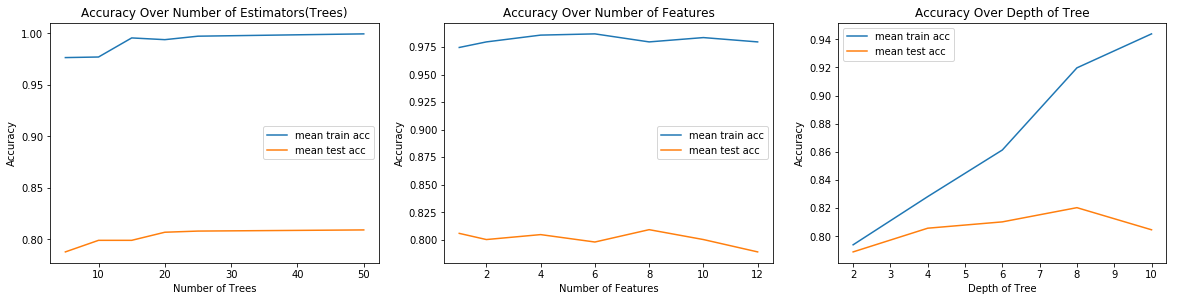

In [117]:
#now plot curves in order
plt.figure(figsize=(20,15))

plt.subplot(331)
plt.plot(estimator_list,train_mean_est,label='mean train acc')
plt.plot(estimator_list,test_mean_est,label='mean test acc')

plt.title('Accuracy Over Number of Estimators(Trees)')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(332)
plt.plot(max_feat_list,train_mean_feat,label='mean train acc')
plt.plot(max_feat_list,test_mean_feat,label='mean test acc')

plt.title('Accuracy Over Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(333)
plt.plot(max_depth_list,train_mean_depth,label='mean train acc')
plt.plot(max_depth_list,test_mean_depth,label='mean test acc')

plt.title('Accuracy Over Depth of Tree')
plt.xlabel('Depth of Tree')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()